## FONDECYT - Estudiando EOD

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
import matplotlib as mpl
import matplotlib.patheffects as path_effects
from sklearn.preprocessing import normalize, LabelEncoder, MinMaxScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
from dython.nominal import cramers_v, theils_u, associations
from sklearn.ensemble import ExtraTreesClassifier

# Por alguna razon no puedo configuar bien el texto usando esta linea
#sns.set(context='notebook', style='whitegrid', palette='Accent', font='Fira Sans')
COLOR = 'black'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
%matplotlib inline


# --------------------------------------- #

def normalize_dataframe(df):
    df = pd.DataFrame(normalize(df, norm='l1'), index=df.index, columns=df.columns)
    return df

def read_parameters(column):
    return pd.read_csv('./2012_eod_stgo/EOD_STGO/Tablas_parametros/'+column+'.csv', sep=';', index_col='Id', encoding= 'unicode_escape')

def remove_outliers(df, column):
    q1 = df[column].quantile(.15)
    q3 = df[column].quantile(.85)
    iqr = q3-q1
    return  df.pipe(lambda x: x[x[column].between(q1-1.5*iqr,q3+1.5*iqr)])

def plot_bar_categorical(df,categorical_1, categorical_2, sorted_by=None, drop_na=False, plot_text=True, print_stats=True):
    if drop_na:
        _df = df[[categorical_1,categorical_2]].dropna()
    else:
        _df  = df[[categorical_1,categorical_2]].fillna("No responde")
    if _df[categorical_1].dtype != 'object':
        if len(_df[categorical_1].unique())<100:
            _df[categorical_1] = _df[categorical_1].astype(np.int)
        else:
            raise TypeError("{} does not look like a categorical column".format(categorical_1))
    if _df[categorical_2].dtype != 'object':
        if len(_df[categorical_2].unique())<100:
            _df[categorical_2] = _df[categorical_2].astype(np.int)
        else:
            raise TypeError("{} does not look like a categorical column".format(categorical_2))

    df_normalized = _df.groupby([categorical_1, categorical_2]).size().unstack().fillna(0)
    if sorted_by==None:
        sorted_by = df_normalized.columns[0]
    print("(Sorting DataFrame by {})\n".format(sorted_by))
    if print_stats:
        print(_df[categorical_1].value_counts(normalize=True),'\n')
        print(_df[categorical_2].value_counts(normalize=True),'\n')
    df_normalized  = normalize_dataframe(df_normalized).sort_values(sorted_by, ascending=True)
    if len(df[categorical_1].unique())<10:
        kind = 'barh'
        rotation = 0
        y_delta = 0.5
    else:
        kind = 'bar'
        rotation = 60
        y_delta = 0.25
    ax = df_normalized.plot(kind=kind, stacked=True, width=0.8, legend=False, figsize=(14,7), cmap='viridis', edgecolor='none')
    if plot_text:
        patch_handles = ax.get_children()
        percentages = df_normalized.values.T.flatten()*100
        for i in range(len(patch_handles)):
            patch = patch_handles[i]
            if isinstance(patch, mpl.patches.Rectangle):
                if percentages[i]==0:
                    continue
                bl = patch.get_xy()
                x = 0.5*patch.get_width() + bl[0]
                y = y_delta*patch.get_height() + bl[1]
                text = ax.text(x,y, "%d%%" % (percentages[i]), ha='center', color='white', rotation=rotation, fontsize=14,
                               fontweight = 'semibold')
                text.set_path_effects([path_effects.Stroke(linewidth=0.7, foreground='black')])
            else:
                break
    sns.despine()
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
    #plt.ylim(0,1)

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5, method='pearson'):
    au_corr = df.corr(method=method).abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]


def time_mapping(time):
    if 5 < time <= 6.5:
        return 'early_morning'
    elif 6.5 < time <= 7.5:
        return 'morning_peak_hour_1'
    elif 7.5 < time <= 9.:
        return 'morning_peak_hour2'
    elif 9. < time < 12:
        return 'morning'
    elif 12 <= time <= 15:
        return 'afternoon_lunch_time'
    elif 15 < time <= 17.5:
        return 'afternoon'
    elif 17.5 < time <= 19:
        return 'afternoon_peak_hour_1'
    elif 19 < time <= 21:
        return 'afternoon_peak_hour_2'
    else:
        return 'night'
    
mode_mapping = {'Auto': 'private',
 'Bus TS': 'bus',
 'Bus no TS': 'bus',
 'Metro': 'rail',
 'Taxi Colectivo': 'shared_taxi',
 'Taxi ': 'private',
 'Bus TS - Bus no TS': 'bus',
 'Auto - Metro': 'intermodal_private',
 'Bus TS - Metro': 'intermodal_public',
 'Bus no TS - Metro': 'intermodal_public',
 'Taxi Colectivo - Metro': 'intermodal_private',
 'Taxi - Metro': 'intermodal_private',
 'Otros - Metro': 'intermodal_public',
 'Otros - Bus TS': 'intermodal_public',
 'Otros - Bus TS - Metro': 'intermodal_public',
 'Otros': 'other',
 'Caminata': 'pedestrian',
 'Bicicleta': 'non_motorized'}

def estudio_mapping(e):
    if e==1:
        return 'Ninguno'
    elif e<=4:
        return 'Primaria'
    elif e<=7:
        return 'Secundaria'
    elif e<=10:
        return 'Superior (no Universitaria)'
    else:
        return 'Universitaria'
    
def add_period(trips, start, end, name):
    index_values = pd.DatetimeIndex(trips.start_datetime).indexer_between_time(start, end)
    trips['period'].iloc[index_values] = name

def add_periods(df):
    df['period'] = 'n/a'
    add_period(df, '6:01', '7:30:59', 'morning_peak_1')
    add_period(df, '7:31', '9:00:59', 'morning_peak_2')
    add_period(df, '9:01', '12:00:59', 'morning_valley')
    add_period(df, '12:01', '17:30:59', 'afternoon_valley')
    add_period(df, '17:31', '20:30:59', 'afternoon_peak')
    add_period(df, '20:31', '23:00:59', 'night_valley')
    add_period(df, '23:01', '23:59:59', 'night')
    add_period(df, '0:00', '6:00:59', 'night')
    return df

In [5]:
urban_zones = gpd.read_file('json/urban_zones_2016.json')
urban_municipalities = set(urban_zones.Comuna.unique())
person = pd.read_csv('./2012_eod_stgo/EOD_STGO/personas.csv', sep=';', decimal=',', index_col=['Persona', 'Hogar'])
eod = pd.read_csv('./2012_eod_stgo/EOD_STGO/viajes.csv', encoding='iso-8859-1', sep=';', index_col='Viaje', decimal=',').join(person, on=['Persona', 'Hogar'])
distances = pd.read_csv('./2012_eod_stgo/EOD_STGO/DistanciaViaje.csv', sep=';', encoding='iso-8859-1', index_col='Viaje')
hogares = pd.read_csv('./2012_eod_stgo/EOD_STGO/Hogares.csv', encoding='iso-8859-1', sep=';', index_col='Hogar', decimal=',')

purposes = pd.read_csv('./2012_eod_stgo/EOD_STGO/Tablas_parametros/Proposito.csv', sep=';', index_col='Id')
modes = pd.read_csv('./2012_eod_stgo/EOD_STGO/Tablas_parametros/ModoAgregado.csv', sep=';', encoding='iso-8859-1', index_col='ID')
sectors = pd.read_csv('./2012_eod_stgo/EOD_STGO/Tablas_parametros/Sector.csv', sep=';', encoding='utf-8', index_col='Sector')
comunas = pd.read_csv('./2012_eod_stgo/EOD_STGO/Tablas_parametros/Comunas.csv', sep=',', encoding='utf-8', index_col='Id')

#mode_per_trip = (pd.read_csv('./2012_eod_stgo/EOD_STGO/ViajesDifusion.csv', sep=';', index_col='Viaje')
#                .join(modes.rename(columns={'ModoDifusion': 'mode_of_transportation'}), on='ModoDifusion'))


In [7]:
trip_features = (eod.join(distances)
 .pipe(lambda x: x[(x['Imputada'] == 0) & (~x.SectorOrigen.isin([0, 7, 9])) & (~x.SectorDestino.isin([0, 7, 9]))])
 .join(purposes.rename(columns={'Proposito': 'purpose'}), on='Proposito')
 .join(modes.rename({'Modo': 'mode_of_transportation'}, axis=1), on='ModoAgregado')
 .assign(distance=lambda x: x['DistEuclidiana'] / 1000)
 .pipe(lambda x: x[x.distance.between(0.5, 50)])
 .pipe(lambda x: x[x.AnoNac < 1995])
 .pipe(lambda x: x[x.mode_of_transportation != 'Otros'])
 #.pipe(lambda x: x[x.purpose.isin(['Al trabajo', 'Al estudio', 'volver a casa'])])
 .pipe(lambda x: x[pd.notnull(x.FactorLaboralNormal) & pd.notnull(x.Factor_LaboralNormal)])
 .join(comunas.rename(columns={'Comuna': 'municipality_origin'}), on='ComunaOrigen')
 .join(comunas.rename(columns={'Comuna': 'municipality_destination'}), on='ComunaDestino')
 .pipe(lambda x: x[x.municipality_origin.isin(urban_municipalities) & x.municipality_destination.isin(urban_municipalities)])
 .assign(weight=lambda x: x['FactorLaboralNormal'] * x['Factor_LaboralNormal'])
 .assign(mode_of_transportation=lambda x: x['mode_of_transportation'].map(lambda m: mode_mapping[m]))
 .assign(sector_origin=lambda x: x['SectorOrigen'].astype(np.int))
 .assign(sector_destination=lambda x: x['SectorDestino'].astype(np.int))
 .join(hogares[['DiaAsig']], on='Hogar')
 .assign(Educacion= lambda x: x['Estudios'].map(lambda e: estudio_mapping(e)))
)

# Agrego el sufijo _desc, lo que se refiere a descripcion
trip_features = (trip_features
                 .join(read_parameters('TramoIngreso'), on='TramoIngresoFinal', rsuffix='_desc')
                 .join(read_parameters('TiempoMedio'), on='TiempoMedio', rsuffix='_desc')
                 .join(read_parameters('Estudios'), on='Estudios', rsuffix='_desc')
                 .join(read_parameters('Ocupacion').rename(columns={'ocupacion': 'Ocupacion_desc'}), on='Ocupacion', )
                )
#trip_features['Ocupacion_desc'].fillna('No responde', inplace=True) 
#trip_features['TramoIngreso_desc'].fillna('No responde', inplace=True)
#trip_features['Estudios'].fillna('No responde', inplace=True)

print(trip_features.shape, trip_features.weight.sum())

trip_features['HoraIni'] = pd.to_timedelta(trip_features['HoraIni'] + ':00')
#trip_features = trip_features[pd.notnull(trip_features['HoraIni'])]
trip_features['HoraInicio'] = trip_features['HoraIni'] / pd.Timedelta(hours=1)
#trip_features['HoraFin'] = pd.to_timedelta(trip_features['HoraFin'] + ':00')
#trip_features = trip_features[pd.notnull(trip_features['HoraFin'])]
#trip_features['HoraFinal'] = trip_features['HoraFin'] / pd.Timedelta(hours=1)
trip_features = (trip_features
 .assign(TramoHoraInicio_desc = lambda x : x['HoraInicio'].map(lambda t: time_mapping(t))
                ))

trip_features['start_datetime'] = pd.to_datetime(trip_features.HoraIni)
trip_features = add_periods(trip_features).drop('start_datetime', axis=1)
trip_features.head()

(41157, 88) 9340914.12474329


,Hogar,Persona,Etapas,ComunaOrigen,ComunaDestino,SectorOrigen,SectorDestino,ZonaOrigen,ZonaDestino,OrigenCoordX,...,sector_destination,DiaAsig,Educacion,TramoIngreso_desc,TiempoMedio_desc,Estudios_desc,Ocupacion_desc,HoraInicio,TramoHoraInicio_desc,period
Viaje,,,,,,,,,,,,,,,,,,,,,
1734310202,173431,17343102,1,94.0,94.0,2.0,2.0,400,407,335208.7188,...,2,jueves,Secundaria,NaN,entre 1 hora y 1 hora 30 minutos,Media CientÃ­fica-Humanista,NaN,22.5,night,night_valley
1734410101,173441,17344101,2,94.0,71.0,2.0,3.0,407,307,338536.4375,...,3,miÃ©rcoles,Secundaria,Entre 200.001 y 400.000 pesos,entre 1 hora 30 minutos y 2 horas,Media CientÃ­fica-Humanista,Empleado u obrero del sector privado,13.0,afternoon_lunch_time,afternoon_valley
1734410102,173441,17344101,2,71.0,94.0,3.0,2.0,307,407,354267.3438,...,2,miÃ©rcoles,Secundaria,Entre 200.001 y 400.000 pesos,entre 1 hora y 1 hora 30 minutos,Media CientÃ­fica-Humanista,Empleado u obrero del sector privado,22.0,night,night_valley
1734410301,173441,17344103,2,94.0,91.0,2.0,3.0,407,437,338536.4375,...,3,miÃ©rcoles,Secundaria,Entre 200.001 y 400.000 pesos,entre 31 minutos y 1 hora,Media CientÃ­fica-Humanista,Empleado u obrero del sector privado,9.0,morning_peak_hour2,morning_peak_2
1734410302,173441,17344103,2,91.0,94.0,3.0,2.0,437,407,350841.6563,...,2,miÃ©rcoles,Secundaria,Entre 200.001 y 400.000 pesos,entre 2 horas y 2 horas 30 minutos,Media CientÃ­fica-Humanista,Empleado u obrero del sector privado,19.0,afternoon_peak_hour_1,afternoon_peak


In [8]:
home_data = pd.read_csv('./2012_eod_stgo/EOD_STGO/Hogares.csv', sep=';', decimal=',')
def weighted_mean(df, value, weight):
    weighted_sum = (df[value] * df[weight]).sum()
    return weighted_sum / df[weight].sum()
zone_income = np.log(home_data.groupby('Zona').apply(lambda x: weighted_mean(x, 'IngresoHogar', 'Factor')))
zone_income.name = 'mean_home_income'
pd.DataFrame(zone_income).to_csv('2017_results/zone_income.csv.gz', compression='gzip')
zone_centroids = urban_zones.to_crs({'init': 'epsg:5361'}).set_index('ID').centroid
zone_positions = np.vstack([zone_centroids.geometry.x, zone_centroids.geometry.y]).T
from scipy.spatial.distance import pdist, squareform
zone_distance_matrix = squareform(pdist(zone_positions)) / 1000
zone_distance_pairs = pd.DataFrame(zone_distance_matrix, 
             index=list(zone_centroids.index), 
             columns=list(zone_centroids.index)).unstack().reset_index()
zone_distance_pairs.columns = ['ZonaOrigen', 'ZonaDestino', 'distance']
zone_distance_pairs = zone_distance_pairs.set_index(['ZonaOrigen', 'ZonaDestino'])
zone_distance_pairs.to_csv('2017_results/zone_distances.csv.gz', compression='gzip')
trip_features = (trip_features
                  .join(zone_income, on='ZonaOrigen', how='inner')
                  .rename({'mean_home_income': 'origin_income'}, axis=1)
                  .join(zone_income, on='ZonaDestino', how='inner')
                  .rename({'mean_home_income': 'destination_income'}, axis=1)
                  .pipe(lambda x: x[x['ZonaOrigen']!=x['ZonaDestino']])
                 )#[['distance', 'mode_of_transportation', 'origin_income', 'destination_income', 'weight', 'period']])
trip_features.head()

/home/vnavarro/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,Hogar,Persona,Etapas,ComunaOrigen,ComunaDestino,SectorOrigen,SectorDestino,ZonaOrigen,ZonaDestino,OrigenCoordX,...,Educacion,TramoIngreso_desc,TiempoMedio_desc,Estudios_desc,Ocupacion_desc,HoraInicio,TramoHoraInicio_desc,period,origin_income,destination_income
Viaje,,,,,,,,,,,,,,,,,,,,,
1734310202,173431,17343102,1,94.0,94.0,2.0,2.0,400,407,335208.7188,...,Secundaria,NaN,entre 1 hora y 1 hora 30 minutos,Media CientÃ­fica-Humanista,NaN,22.500000,night,night_valley,13.551591,13.382223
1760710102,176071,17607101,1,94.0,94.0,2.0,2.0,400,407,335193.9688,...,Secundaria,Entre 200.001 y 400.000 pesos,entre 31 minutos y 1 hora,Media CientÃ­fica-Humanista,Empleado u obrero del sector privado,21.333333,night,night_valley,13.551591,13.382223
1851030102,185103,18510301,1,94.0,94.0,2.0,2.0,400,407,335231.0938,...,Secundaria,Entre 200.001 y 400.000 pesos,menor o igual a 30 minutos,Media CientÃ­fica-Humanista,Trabajador por cuenta propia,14.500000,afternoon_lunch_time,afternoon_valley,13.551591,13.382223
1734410102,173441,17344101,2,71.0,94.0,3.0,2.0,307,407,354267.3438,...,Secundaria,Entre 200.001 y 400.000 pesos,entre 1 hora y 1 hora 30 minutos,Media CientÃ­fica-Humanista,Empleado u obrero del sector privado,22.000000,night,night_valley,13.685452,13.382223
1734410302,173441,17344103,2,91.0,94.0,3.0,2.0,437,407,350841.6563,...,Secundaria,Entre 200.001 y 400.000 pesos,entre 2 horas y 2 horas 30 minutos,Media CientÃ­fica-Humanista,Empleado u obrero del sector privado,19.000000,afternoon_peak_hour_1,afternoon_peak,13.982211,13.382223


In [9]:
trip_features.columns

Index(['Hogar', 'Persona', 'Etapas', 'ComunaOrigen', 'ComunaDestino',
       'SectorOrigen', 'SectorDestino', 'ZonaOrigen', 'ZonaDestino',
       'OrigenCoordX', 'OrigenCoordY', 'DestinoCoordX', 'DestinoCoordY',
       'Proposito', 'PropositoAgregado', 'ActividadDestino', 'MediosUsados',
       'ModoAgregado', 'ModoPriPub', 'ModoMotor', 'HoraIni', 'HoraFin',
       'HoraMedia', 'TiempoViaje', 'TiempoMedio', 'Periodo', 'MinutosDespues',
       'CuadrasDespues', 'FactorLaboralNormal', 'FactorSabadoNormal',
       'FactorDomingoNormal', 'FactorLaboralEstival',
       'FactorFindesemanaEstival', 'CodigoTiempo', 'AnoNac', 'Sexo',
       'Relacion', 'Viajes', 'LicenciaConducir', 'PaseEscolar', 'AdultoMayor',
       'Estudios', 'Curso', 'Actividad', 'Ocupacion', 'ActividadEmpresa',
       'JornadaTrabajo', 'DondeEstudia', 'DirActividadCoordX',
       'DirActividadCoordY', 'DirEstudiosCoordX', 'DirEstudiosCoordY',
       'NoViaja', 'TarjetaBip', 'Tarjeta2Bip', 'MedioViajeRestricion',
       'C

In [10]:
mindist_df = pd.read_csv('2020_results/mindist_zonahogar.csv')
#mindist_df = pd.read_csv('data_distances/mindist.csvwi').set_index('Viaje').join(trip_features[['ZonaOrigen', 'ZonaDestino']])
#mindist_zonaorigen =mindist_df.groupby(['ZonaOrigen'])['origen_mindist_taxi', 'origen_mindist_stop', 'origen_mindist_metro'].median()
#mindist_zonadestino =mindist_df.groupby(['ZonaDestino'])['destino_mindist_taxi', 'destino_mindist_stop', 'destino_mindist_metro'].median()
mindist_df.head()

,Zona,mindist_taxi,mindist_stop,mindist_metro
0,1,0.000772,0.000627,0.010117
1,2,0.000366,0.001027,0.005358
2,3,0.000734,0.000863,0.004774
3,4,0.000342,0.001000,0.003679
4,5,0.002662,0.001149,0.003796


In [11]:
#trip_features = trip_features.join(mindist_zonaorigen, on='ZonaOrigen').join(mindist_zonadestino, on='ZonaDestino')

trip_features = (trip_features.join(mindist_df.groupby('Zona').mean().add_prefix('origen_'), on='ZonaOrigen')
                              .join(mindist_df.groupby('Zona').mean().add_prefix('destino_'), on='ZonaDestino')
                )

In [12]:
trip_features2 = trip_features
trip_features2 = trip_features2.apply(lambda col: LabelEncoder().fit_transform(col.astype(str)), axis=0, result_type='expand')

In [13]:
X = trip_features2[['distance', #'education_zone_origin', 'education_zone_destination', #'IngresoMedio_ComunaOrigen', 'IngresoMedio_ComunaDestino',
                    'origen_mindist_taxi', 'origen_mindist_stop', 'origen_mindist_metro',
                    'destino_mindist_taxi', 'destino_mindist_stop', 'destino_mindist_metro',
                    'origin_income', 'destination_income']]#, 'taxi_cnt', 'metro_cnt', 'stops_cnt']]
y = trip_features2['mode_of_transportation']

#X = trip_features2.drop(columns=['mode_of_transportation'])

Feature ranking:
1. feature 0 (distance) (0.29208)
2. feature 3 (origen_mindist_metro) (0.10202)
3. feature 6 (destino_mindist_metro) (0.10160)
4. feature 7 (origin_income) (0.09361)
5. feature 8 (destination_income) (0.09292)
6. feature 2 (origen_mindist_stop) (0.08032)
7. feature 5 (destino_mindist_stop) (0.07983)
8. feature 1 (origen_mindist_taxi) (0.07897)
9. feature 4 (destino_mindist_taxi) (0.07867)


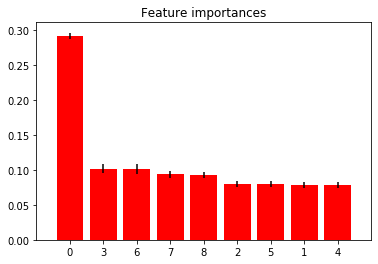

In [14]:
forest = ExtraTreesClassifier(n_estimators=250, random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(importances.shape[0]):
    print("{}. feature {} ({}) ({:.5f})".format(f + 1, indices[f], X.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(importances.shape[0]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(importances.shape[0]), indices)
plt.xlim([-1, importances.shape[0]])
plt.show()


Al parecer hacer un *Feature Selection* con clasificadores como `ExtraTree` o `RandomForest` da una buena impresión de cuales son las columnas importantes

In [202]:
feature_matrix = trip_features[['distance', 'mode_of_transportation', 'origin_income', 'destination_income', 'origen_mindist_taxi', 'origen_mindist_metro',
                                'origen_mindist_stop', 'destino_mindist_taxi', 'destino_mindist_metro', 'destino_mindist_stop', 'weight', 'period']]
feature_matrix['mode_of_transportation'] = pd.Categorical(feature_matrix['mode_of_transportation'])

feature_matrix['mode_code'] = feature_matrix['mode_of_transportation'].cat.codes
feature_matrix.head()

/home/vnavarro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/vnavarro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,distance,mode_of_transportation,origin_income,destination_income,origen_mindist_taxi,origen_mindist_metro,origen_mindist_stop,destino_mindist_taxi,destino_mindist_metro,destino_mindist_stop,weight,period,mode_code
Viaje,,,,,,,,,,,,,
1734310202,5.387,bus,13.551591,13.382223,0.002503,0.024532,0.000960,0.000802,0.01332,0.001192,142.337500,night_valley,0
1760710102,5.406,non_motorized,13.551591,13.382223,0.002503,0.024532,0.000960,0.000802,0.01332,0.001192,148.500883,night_valley,3
1851030102,5.856,non_motorized,13.551591,13.382223,0.002503,0.024532,0.000960,0.000802,0.01332,0.001192,218.391272,afternoon_valley,3
1734410102,18.841,intermodal_public,13.685452,13.382223,0.001440,0.005825,0.001353,0.000802,0.01332,0.001192,127.328613,night_valley,2
1734410302,13.392,intermodal_public,13.982211,13.382223,0.001145,0.024327,0.001302,0.000802,0.01332,0.001192,108.989137,afternoon_peak,2


In [210]:
for c in feature_matrix.columns[4:10]:
    feature_matrix[c] = np.sqrt(feature_matrix[c])
feature_matrix.head()

/home/vnavarro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,distance,mode_of_transportation,origin_income,destination_income,origen_mindist_taxi,origen_mindist_metro,origen_mindist_stop,destino_mindist_taxi,destino_mindist_metro,destino_mindist_stop,weight,period,mode_code
Viaje,,,,,,,,,,,,,
1734310202,5.387,bus,13.551591,13.382223,0.050030,0.156626,0.030977,0.028319,0.115412,0.034524,142.337500,night_valley,0
1760710102,5.406,non_motorized,13.551591,13.382223,0.050030,0.156626,0.030977,0.028319,0.115412,0.034524,148.500883,night_valley,3
1851030102,5.856,non_motorized,13.551591,13.382223,0.050030,0.156626,0.030977,0.028319,0.115412,0.034524,218.391272,afternoon_valley,3
1734410102,18.841,intermodal_public,13.685452,13.382223,0.037948,0.076322,0.036779,0.028319,0.115412,0.034524,127.328613,night_valley,2
1734410302,13.392,intermodal_public,13.982211,13.382223,0.033831,0.155970,0.036086,0.028319,0.115412,0.034524,108.989137,afternoon_peak,2


In [211]:
feature_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39059 entries, 1734310202 to 2202300402
Data columns (total 13 columns):
distance                  39059 non-null float64
mode_of_transportation    39059 non-null category
origin_income             39059 non-null float64
destination_income        39059 non-null float64
origen_mindist_taxi       39059 non-null float64
origen_mindist_metro      39059 non-null float64
origen_mindist_stop       39059 non-null float64
destino_mindist_taxi      39059 non-null float64
destino_mindist_metro     39059 non-null float64
destino_mindist_stop      39059 non-null float64
weight                    39059 non-null float64
period                    39059 non-null object
mode_code                 39059 non-null int8
dtypes: category(1), float64(10), int8(1), object(1)
memory usage: 4.9+ MB


## Training the Model

In [212]:
#formula = 'C(mode_of_transportation) ~ distance + C(IngresoMedio_ComunaOrigen) + C(IngresoMedio_ComunaDestino) + C(period)' #C(TramoIngreso_ComunaOrigen)'
#formula = 'C(mode_of_transportation) ~ distance + origin_income + destination_income +  C(period)'
# + origen_mindist_stop + destino_mindist_stop
formula = ('mode_code ~ distance + origin_income + destination_income + origen_mindist_stop + destino_mindist_stop + origen_mindist_taxi + destino_mindist_taxi + origen_mindist_metro + destino_mindist_metro + C(period)')

In [213]:
mnlogit_model = smf.mnlogit(formula, feature_matrix, freq_weights=feature_matrix['weight'])
model_results = mnlogit_model.fit()
model_results.summary()

Optimization terminated successfully.
         Current function value: 1.323773
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:              mode_code   No. Observations:                39059
Model:                        MNLogit   Df Residuals:                    38947
Method:                           MLE   Df Model:                          105
Date:                Thu, 04 Jun 2020   Pseudo R-squ.:                  0.2424
Time:                        12:08:48   Log-Likelihood:                -51705.
converged:                       True   LL-Null:                       -68251.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================================
                  mode_code=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                       -19.9400      1.755    -11.359      0.000     -23.381     -16.499
C(period)[T.afternoon_valley]    -0.2235      0.118     -1.895      0.058      -0.455       0.008
C(period)[T.morning_peak_1]       0.0340      0.136      0.249      0.803      -0.233       0.301
C(period)[T.morning_peak_2]      -0.0594      0.142     -0.418      0.676      -0.338       0.219
C(period)[T.morning_valley]      -0.1907      0.143     -1.332      0.183      -0.471       0.090
C(period)[T.night]               -1.1503      0.303     -3.803      0.000      -1.743      -0.557
C(period)[T.night_valley]         0.0133      0.194      0.068      0.945      -0.367       0.393
distance                          0.2020      0.008     25.929      0.000       0.187       0.217
origin_income                     0.5704      0.093      6.130      0.000       0.388       0.753
destination_income                0.7387      0.097      7.638      0.000       0.549       0.928
origen_mindist_stop              31.8279      3.799      8.377      0.000      24.381      39.274
destino_mindist_stop             19.0467      5.893      3.232      0.001       7.497      30.597
origen_mindist_taxi             -12.3192      1.914     -6.437      0.000     -16.070      -8.568
destino_mindist_taxi            -11.3065      1.920     -5.888      0.000     -15.070      -7.543
origen_mindist_metro            -13.3605      0.971    -13.765      0.000     -15.263     -11.458
destino_mindist_metro           -12.9295      0.994    -13.001      0.000     -14.879     -10.980
-------------------------------------------------------------------------------------------------
                  mode_code=2       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                       -10.7324      0.739    -14.520      0.000     -12.181      -9.284
C(period)[T.afternoon_valley]    -0.1181      0.052     -2.278      0.023      -0.220      -0.016
C(period)[T.morning_peak_1]       0.0854      0.061      1.391      0.164      -0.035       0.206
C(period)[T.morning_peak_2]       0.0165      0.064      0.259      0.796      -0.108       0.141
C(period)[T.morning_valley]      -0.4383      0.067     -6.526      0.000      -0.570      -0.307
C(period)[T.night]               -0.3147      0.096     -3.287      0.001      -0.502      -0.127
C(period)[T.night_valley]         0.0916      0.087      1.048      0.295      -0.080       0.263
distance                          0.1874      0.003     54.179      0.000       0.181       0.194
origin_income                     0.3396      0.042      8.079      0.000       0.257       0.422
destination_income                0.3669      0.042      8.815      0.000       0.285       0.448
origen_mindist_stop              10.8821      2.486      4.378      0.000       6.010      15.754
destino

In [214]:
# Me sigue explotando el notebook en esta parte xD

#marginal_effects = model_results.get_margeff()
#marginal_effects.summary()

In [215]:
import json
# sadly statsmodels doesn't save this. presumably it's in alphabetical order, but it's better to check.
column_names = list(feature_matrix.mode_of_transportation.cat.categories)
print(column_names)

with open('2020_results/mnlogit_column_names.json', 'wt') as f:
    json.dump(column_names, f)
# --------------------------------------- #

['bus', 'intermodal_private', 'intermodal_public', 'non_motorized', 'pedestrian', 'private', 'rail', 'shared_taxi']


In [216]:
import joblib

joblib.dump(model_results, '2020_results/mnlogit_zone_model_instance.joblib.gz')

['2020_results/mnlogit_zone_model_instance.joblib.gz']

In [217]:
predictions = model_results.predict(feature_matrix)
predictions.columns = column_names
predictions['model_mode'] = predictions.idxmax(axis=1)
predictions = predictions.join(trip_features.municipality_origin)
predictions.model_mode.unique()

array(['private', 'intermodal_public', 'bus', 'pedestrian', 'rail',
       'shared_taxi'], dtype=object)

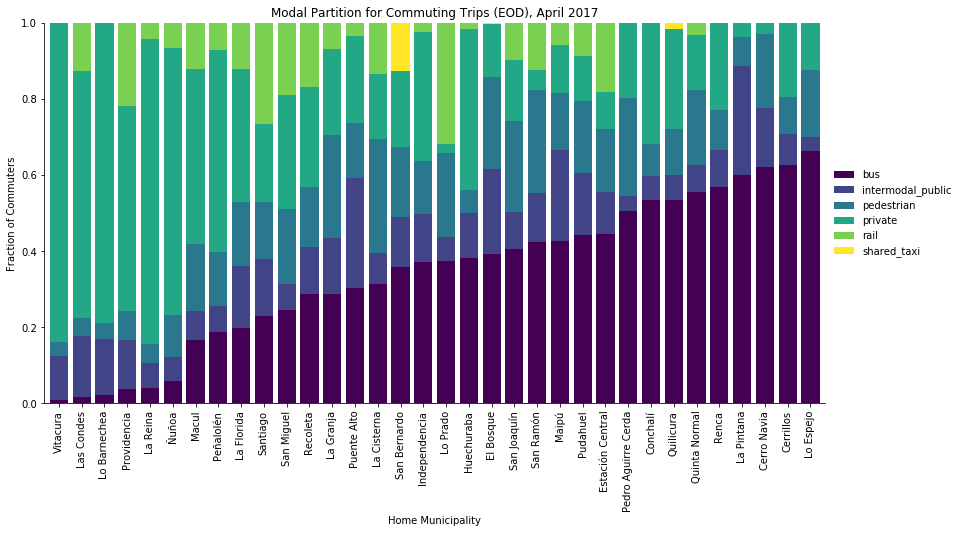

In [218]:
modal_partition = predictions.groupby(['municipality_origin', 'model_mode']).size().reset_index()
modal_partition = modal_partition.pivot_table(index='municipality_origin', columns='model_mode').fillna(0)
modal_partition = pd.DataFrame(normalize(modal_partition, norm='l1'), index=modal_partition.index, columns=modal_partition.columns.levels[1])
modal_partition

ax = (modal_partition.sort_values('bus')
 #.pipe(lambda x: x.loc[:,label_order].copy())
 .plot(kind='bar', stacked=True, width=0.8, legend=False, figsize=(14,7), cmap='viridis', edgecolor='none')
)
patch_handles = ax.get_children()
percentages = modal_partition.sort_values('bus').values.T.flatten()*100
for i in range(len(patch_handles)):
    patch = patch_handles[i]
    if isinstance(patch, mpl.patches.Rectangle):
        if percentages[i]==0:
            continue
        bl = patch.get_xy()
        #x = 0.5*patch.get_width() + bl[0]
        #y = 0.25*patch.get_height() + bl[1]
        #text = ax.text(x,y, "%d%%" % (percentages[i]), ha='center', color='white', rotation=45, fontsize=14,
        #               fontweight = 'semibold')
        #text.set_path_effects([path_effects.Stroke(linewidth=0.7, foreground='black')])
    else:
        break

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
plt.xlabel('')
plt.ylabel('Fraction of Commuters')
plt.xlabel('Home Municipality')
plt.title('Modal Partition for Commuting Trips (EOD), April 2017')
plt.ylim([0, 1])
sns.despine()

(Sorting DataFrame by bus)



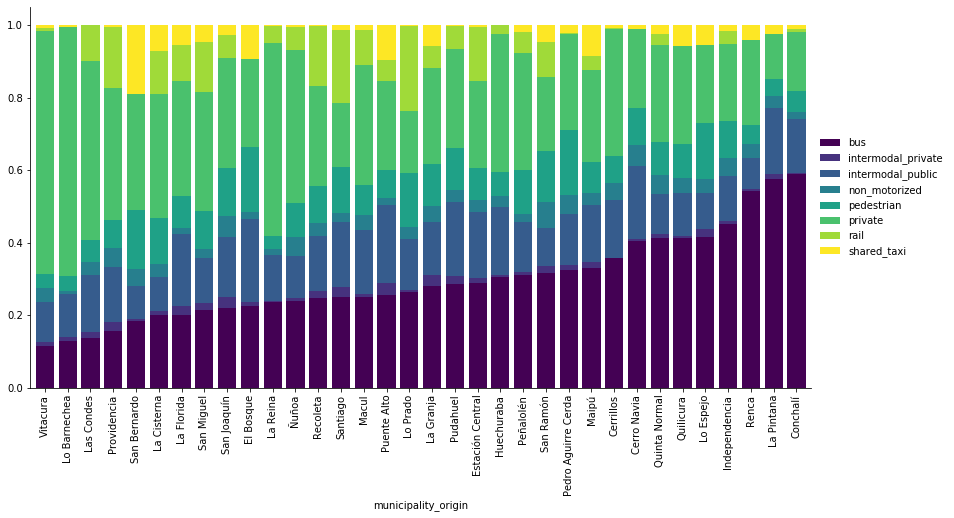

In [219]:
plot_bar_categorical(trip_features , 'municipality_origin', 'mode_of_transportation', plot_text=False, print_stats=False) #'mode_of_transportation'

In [29]:
import joblib

joblib.dump(model_results, '2020_results/mnlogit_zone_model_instance.joblib.gz')

['2020_results/mnlogit_zone_model_instance.joblib.gz']

In [51]:
predictions.join(trip_features[['ZonaOrigen', 'ZonaDestino']]).set_index(['ZonaOrigen', 'ZonaDestino'])

motorized  non_motorized    public  share_taxi  \
ZonaOrigen ZonaDestino                                                   
400        407           0.474885       0.023890  0.460859    0.040366   
           407           0.516260       0.027570  0.423713    0.032456   
           407           0.359781       0.021876  0.568511    0.049833   
           410           0.294077       0.166277  0.472367    0.067280   
           20            0.213968       0.000014  0.781589    0.004429   
...                           ...            ...       ...         ...   
257        770           0.222256       0.155727  0.413442    0.208574   
           118           0.355213       0.191638  0.382527    0.070622   
632        639           0.064671       0.231785  0.529235    0.174309   
           196           0.094606       0.092583  0.607073    0.205738   
782        107           0.987271       0.000031  0.012590    0.000108   

                       model_mode municipality_origin  
ZonaOrigen ZonaDestino                                 
400        407          motorized               Maipú  
           407          motorized               Maipú  
           407             public               Maipú  
           410             public               Maipú  
           20              public               Maipú  
...                           ...                 ...  
257        770             public          La Pintana  
           118             public          La Pintana  
632        639             public         San Joaquín  
           196             public         San Joaquín  
782        107          motorized        San Bernardo  

[39284 rows x 6 columns]

In [44]:
predictions.drop(columns=['model_mode', 'municipality_origin']).to_csv('2020_results/prior_04042020.csv')

In [49]:
trip_features.head()

,Hogar,Persona,Etapas,ComunaOrigen,ComunaDestino,SectorOrigen,SectorDestino,ZonaOrigen,ZonaDestino,OrigenCoordX,...,destino_mindist_stop,destino_mindist_metro,taxi_cnt,metro_cnt,stops_cnt,IngresoMedio_ComunaOrigen,IngresoMedio_ComunaDestino,TramoIngreso_ComunaOrigen,education_zone_origin,education_zone_destination
0,173431,17343102,1,94.0,94.0,2.0,2.0,400,407,335208.7188,...,0.001196,0.017259,5.0,0.0,23.0,239060,239060,None,Secundaria,Secundaria
1,176071,17607101,1,94.0,94.0,2.0,2.0,400,407,335193.9688,...,0.002660,0.007725,5.0,0.0,23.0,239060,239060,Ingreso entre 250000 y 300000,Secundaria,Secundaria
2,185103,18510301,1,94.0,94.0,2.0,2.0,400,407,335231.0938,...,0.001731,0.012187,5.0,0.0,23.0,239060,239060,Ingreso entre 200000 y 250000,Secundaria,Secundaria
3,173901,17390101,1,94.0,94.0,2.0,2.0,400,410,335624.0000,...,0.000447,0.001009,5.0,0.0,23.0,239060,239060,Ingreso entre 0 y 200000,Secundaria,Secundaria
4,174491,17449101,2,94.0,70.0,2.0,4.0,400,20,335511.3438,...,0.001289,0.000351,5.0,0.0,23.0,239060,317528,None,Secundaria,Secundaria
